In [66]:
from datasets import load_dataset
from datasets import Dataset

!pip install -U datasets

dataset = load_dataset("csv", data_files="hate_train.csv", cache_dir=None)['train']
dataset = dataset.train_test_split(test_size=0.2, seed=42)
dataset = dataset.rename_column("sentence", "text")
print(dataset)

with open("hate_test_data.txt", encoding="utf-8") as f:
    test_lines = [line.strip() for line in f if line.strip()]

test_dataset = Dataset.from_dict({"text": test_lines})
print(test_dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 8032
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2009
    })
})
Dataset({
    features: ['text'],
    num_rows: 1000
})


In [67]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("sdadas/polish-roberta-base-v2")

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=512)

tokenized_train_dataset = dataset["train"].map(tokenize_function, batched=True)
tokenized_val_dataset = dataset["test"].map(tokenize_function, batched=True)
tokenized_test_dataset = test_dataset.map(tokenize_function, batched=True)

print(tokenized_train_dataset)
print(tokenized_val_dataset)
print(tokenized_test_dataset)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 8032
})
Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 2009
})
Dataset({
    features: ['text', 'input_ids', 'attention_mask'],
    num_rows: 1000
})


In [68]:
from transformers import AutoModelForSequenceClassification
import torch

model = AutoModelForSequenceClassification.from_pretrained("sdadas/polish-roberta-base-v2", num_labels=2)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at sdadas/polish-roberta-base-v2 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50001, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [69]:
from transformers import TrainingArguments

training_args = TrainingArguments(output_dir="test_trainer", eval_strategy="steps", report_to="none",
                                  per_device_eval_batch_size=32, per_device_train_batch_size=32,
                                  logging_steps=50, fp16=True, num_train_epochs=6,
                                  load_best_model_at_end=True, metric_for_best_model="accuracy", greater_is_better=True, save_strategy="steps",
                                  learning_rate=2e-5,)

In [70]:
!pip install evaluate

import numpy as np
from evaluate import load

metric = load("accuracy")

def compute_metrics(eval_pred):
  logits, labels = eval_pred
  predictions = np.argmax(logits, axis=-1)
  return metric.compute(predictions=predictions, references=labels)

In [71]:
from transformers import Trainer

labels = dataset["train"]["label"]
class_counts = np.bincount(labels)
class_weights = 1. / class_counts ** 0.1
class_weights = class_weights / class_weights.sum()
weights = torch.tensor(class_weights, dtype=torch.float).to(device)

def compute_loss_func(outputs, labels, num_items_in_batch=None):
    loss_fct = torch.nn.CrossEntropyLoss(weight=weights)
    return loss_fct(outputs.logits, labels)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    compute_metrics=compute_metrics,
    compute_loss_func=compute_loss_func
)

In [72]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy
50,0.351700,0.254062,0.914385
100,0.288200,0.230739,0.924340
150,0.248700,0.225395,0.908910
200,0.226400,0.232207,0.915381
250,0.247000,0.272093,0.921354
300,0.210200,0.220070,0.913888
350,0.170900,0.216497,0.918367
400,0.182800,0.263190,0.924340
450,0.172300,0.235317,0.913888
500,0.200100,0.204789,0.931807


TrainOutput(global_step=1506, training_loss=0.13004744488246253, metrics={'train_runtime': 1655.4137, 'train_samples_per_second': 29.112, 'train_steps_per_second': 0.91, 'total_flos': 1.267984797990912e+16, 'train_loss': 0.13004744488246253, 'epoch': 6.0})

In [73]:
eval_results = trainer.evaluate(tokenized_val_dataset)
print(f"Final accuracy: {eval_results['eval_accuracy']:.4f}")
print(trainer.state.best_model_checkpoint)

Final accuracy: 0.9318
test_trainer/checkpoint-500


In [74]:
results = trainer.predict(tokenized_val_dataset)
predictions = results.predictions
true_labels = results.label_ids
predicted_labels = np.argmax(predictions, axis=-1)

Accuracy: 0.9318

              precision    recall  f1-score  support
Normal         0.948285  0.978758  0.963281   1836.0
Hate           0.657895  0.433526  0.522648    173.0
macro avg      0.803090  0.706142  0.742964   2009.0
weighted avg   0.923279  0.931807  0.925337   2009.0



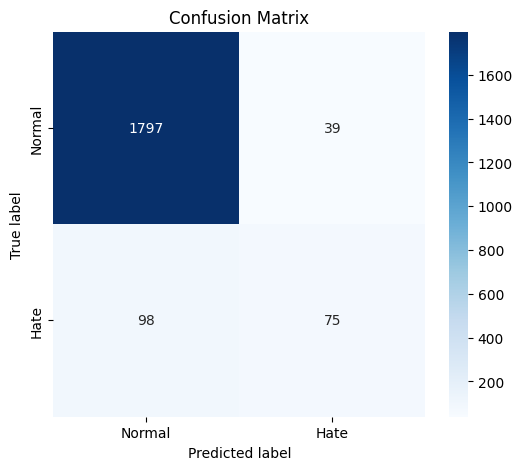

In [75]:
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

label_names = ["Normal", "Hate"]

report = classification_report(true_labels, predicted_labels, output_dict=True, target_names=label_names)
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print(f"Accuracy: {report['accuracy']:.4f}")
print()
report_df = pd.DataFrame(report).transpose()
report_df = report_df.drop(['accuracy'], errors='ignore')
print(report_df)
print()

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

In [76]:
preds = trainer.predict(tokenized_test_dataset)
predictions = np.argmax(preds.predictions, axis=-1)

In [77]:
import pandas as pd

pd.Series(predictions).to_csv("pred.csv", index=False, header=False)